<h1 style="text-align: center;"><b>Линейная, LASSO, Ridge регрессии и их оптимизация.</b></h1>

Сегодня мы поработаем с оптимизацией в линейных алгоритмах (линейная регрессия и логистическая регрессия), а также разберем способы регуляризации данных методов.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 1. Линейная регрессия

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ --- целевая переменная (что мы хотим предсказать), $x_i$ --- признак объекта $х$, $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle w, x \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ Y = Xw, $$ где $Y$ -- столбец размера $n$, $X$ --- матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $w$ -- вектор весов размера $k$.

**Лосс (функция потерь):** 
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

### 1.1 Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$

Реализуем класс линейной регрессии с помощью этой формулы.

#### Тестирование
Сначала сгенерируем искусственные данные для теста моделей по формуле $ y = 6*x + 11 + \epsilon$

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
# по признакам сгенерируем значения таргетов с некоторым шумом

formula = lambda x: 6 * x + 11

objects_num = 100
X = np.linspace(-10, 10, objects_num)
y = formula(X) + np.random.randn(objects_num) * 12

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

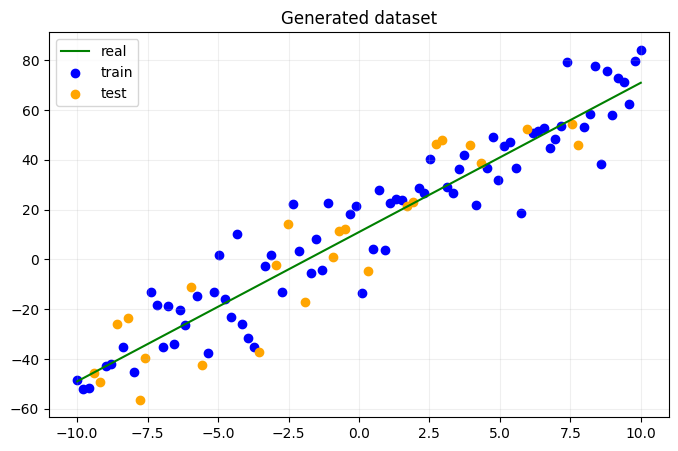

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(X, formula(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [9]:
# Обучим модель на трейне и предскажем результаты на тесте

model = LinearRegression()

model.fit(X_train.reshape(-1, 1), y_train)

y_pred = model.predict(X_test.reshape(-1, 1))

In [10]:
print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"Real:\ny = 6.00x + 11.00")

Predicted:
y = 5.96x + 12.19
Real:
y = 6.00x + 11.00


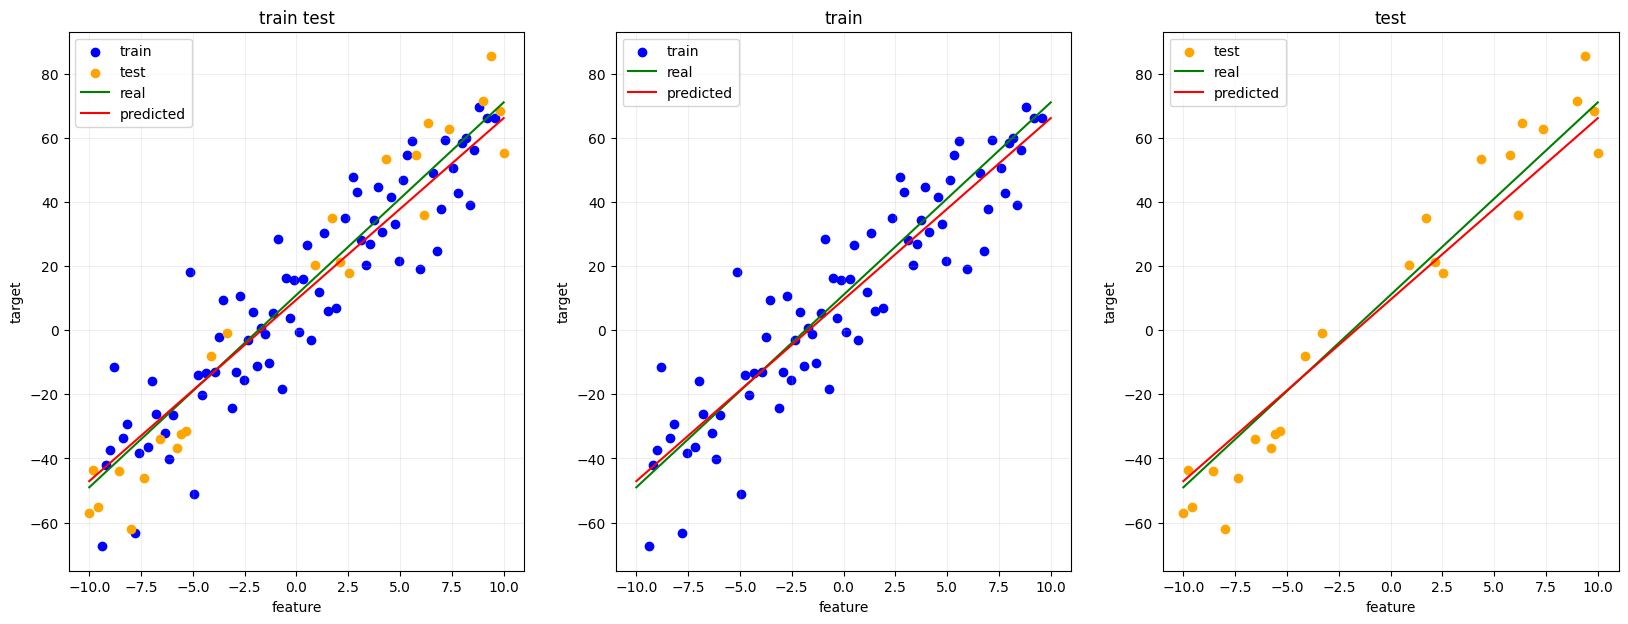

In [7]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)

Train MSE:  177.57359908871024
Test MSE:  154.03137434921152
Train RMSE:  13.325674432789894
Test RMSE:  12.41093769016715


In [9]:
pd.Series(y).describe()

count    100.000000
mean       9.563514
std       37.667483
min      -67.356713
25%      -18.731131
50%       11.212617
75%       39.690216
max       85.386214
dtype: float64

# 2. О регуляризации

Зачастую модель обучается на каких-то зашумленных данных. Веса модели после обучения подбираются для уменьшения ошибки целевой функции. От различных выборках модель может обучаться по-разному, но нам бы хотелось вычленять основную зависимость примерно одинаково, то есть **не переобучаться (overfit)** на данных. Иначе обучившись на одном сете, мы можем получать неожиданный результат на других данных.

То есть мы хотели бы штрафовать модель за ее сложность, чтобы выискивать более простые зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**, т.е. ситуация, когда один признак является линейной комбинацией других. 

Из-за мультиколлинеарности могут получать очень большие коэффициенты. Отсюда вывод: необходимо каким-то образом ограничить величину коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации. Различают:
- $l_1$-регуляризацию (LASSO, least absolute shrinkage and selection operator), учитывание $||w||_1$ 
- $l_2$-регуляризацию (Ridge), учитывание $||w||^2_2$
- Elastic net - комбинация двух предыдущих (учитываются обе нормы весов)

# 2.1 Ridge регрессия (l2 регуляризация)

В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:** $L(w) = ||Xw - Y||^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}w_j^2$


Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

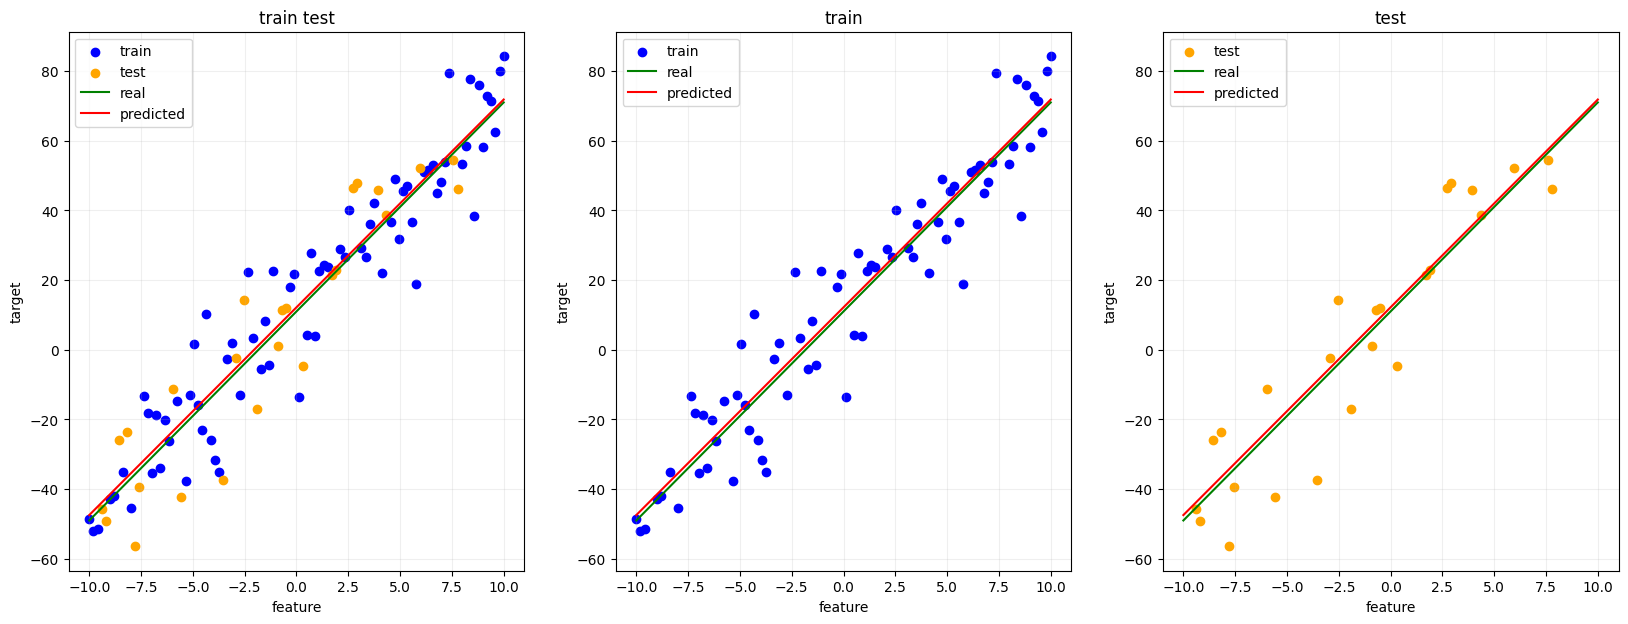

Predicted:
y = 5.96x + 12.19
Real:
y = 6.00x + 11.00
Train MSE:  129.33261851507342
Test MSE:  171.88146259602192
Train RMSE:  11.372449978569852
Test RMSE:  13.110357073551503


In [15]:
from sklearn.linear_model import Ridge

model = Ridge()

model.fit(X_train[:, np.newaxis], y_train)

y_pred = model.predict(X_test[:, np.newaxis])


plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"Real:\ny = 6.00x + 11.00")
train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)


Решение получилось таким же, так как под капотом в sklearn в ridge регуляризации используется МНК, т.е. мы находим аналитическое решение через матрицы.

# 2.2 LASSO регрессия (l1 регуляризация)

В LASSO мы штрафуем модель также **на сумму модулей всех ее весов** (на l1-норму весов), таким образом:

**Лосс:** $L(w) = \frac{1}{2n} ||Xw - Y||^2_2 + \lambda ||w||_1$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \frac{1}{2n}\sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}|w_j|$

Признаки опять же должны быть стандартизованы для одинаковых штрафов относительно друг друга!

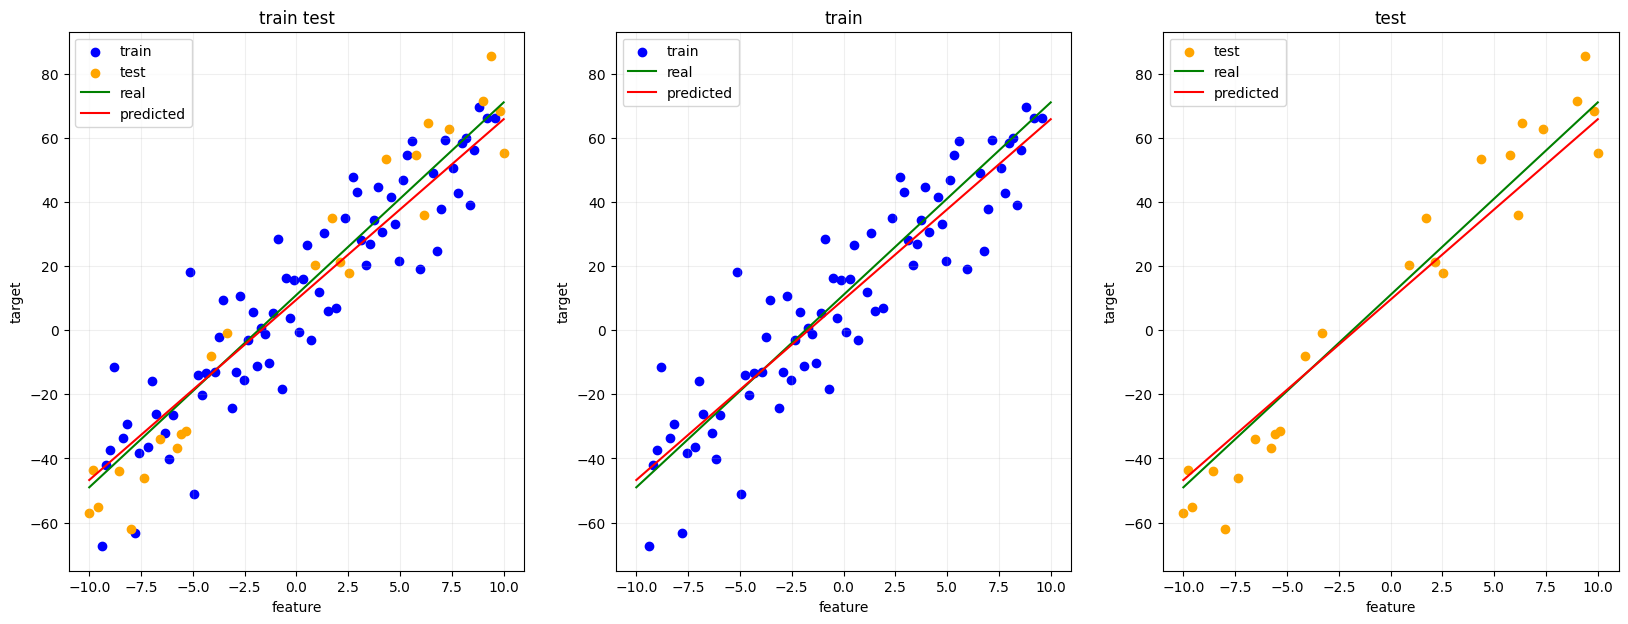

Predicted:
y = 5.62x + 9.52
Real:
y = 6.00x + 11.00
Train MSE:  177.60782640630737
Test MSE:  157.57741404902518
Train RMSE:  13.326958633023041
Test RMSE:  12.552984268652024


In [16]:
from sklearn.linear_model import Lasso

model = Lasso()

model.fit(X_train[:, np.newaxis], y_train)

y_pred = model.predict(X_test[:, np.newaxis])


plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"Real:\ny = 6.00x + 11.00")
train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)

Здесь можем наблюдать различия, так как теперь решение находится не через МНК, а стохастически.

# 2.3 Различия LASSO и Ridge

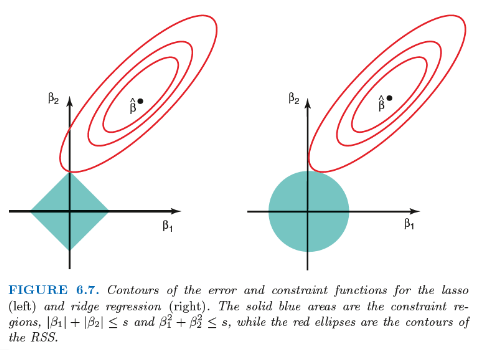

Различий несколько между $l_1$ и $l_2$ регуляризациями:

- Lasso **сложнее считать** из-за недифференцируемых углов шара в $l_1$ норме (в значении нуля для признаков)
- **отсутствие аналитического решения** делает вычисления и теоретические значения весов при $l_1$ регуляризации более сложными
- В Lasso появляется **зануление весов** для некоторых признаков

### 3. Градиентная оптимизация

Обращение матрицы -- очень долгая операция. Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

Градиентый спуск заключается в 
1. расчете $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$)
2. шаге спуска -- изменении весов $w$ в сторону антиградиента с некоторым коэффициентом $h$ (он же learning rate):
$$w := w - h\frac{\partial{L}}{\partial{w}}$$
3. Повторении п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют)

Как правило, чаще используют стохастический градиентный спуск (SGD): выбирают случайный элемент обучающей выборки и изменяют коэффициенты модели по направлению антиградиента функции потерь на этом примере.

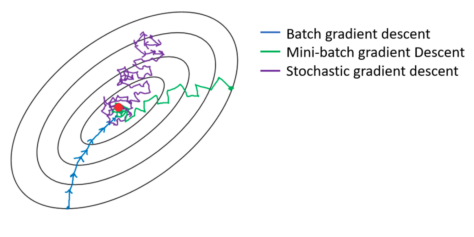

**Цель:** Реализуем новые классы линейной регрессии, в которой оптимизация проводится методами градиентного спуска.

**Предполагаемая зависимость:** $Y = Xw$, где $Y \in \mathbb{R}^{n\times 1}, X \in \mathbb{R}^{n\times m}, w \in \mathbb{R}^{m\times 1}$


**Минимизируемая функция:**
$$
L(y_{pred}, Y) = \frac{1}{n} ||y_{pred} - Y||^2 = \frac{1}{n}||Xw - Y||^2 = \frac{1}{n}(Xw - Y)^T(Xw - Y) = \frac{1}{n}(w^TX^TXw - 2Y^TXw + Y^TY)
$$

**Градиент w.r.t. $w$:**
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TXw - X^TY) = \frac{2}{n}X^T(y_{pred} - Y) \,\, \in \mathbb{R}^{m \times 1}
$$

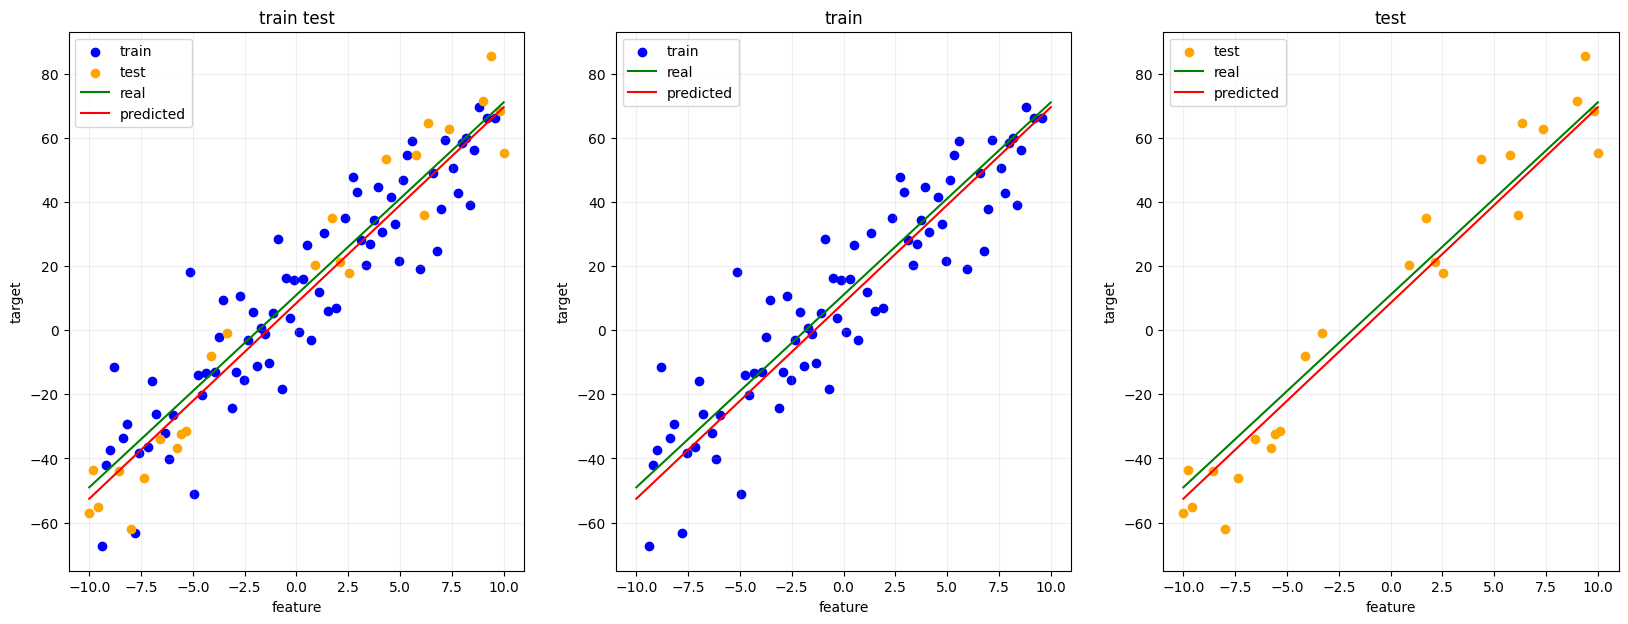

Predicted:
y = 6.10x + 8.47
Real:
y = 6.00x + 11.00
Train MSE:  184.32421718824358
Test MSE:  120.1107056598576
Train RMSE:  13.576605510518585
Test RMSE:  10.959502984162082


In [36]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(max_iter=100_000_000, penalty='elasticnet', l1_ratio=1e-9)

model.fit(X_train[:, np.newaxis], y_train)

y_pred = model.predict(X_test[:, np.newaxis])


plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_[0]:.2f}")
print(f"Real:\ny = 6.00x + 11.00")
train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)

# Практика

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split


In [16]:
df = pd.read_csv("./data/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [18]:
pd.get_dummies(df['region']).head(3)

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0


In [19]:
pd.get_dummies(df['region'], drop_first=True).head(3)

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0


In [21]:
map_dict = {'male':1, 'female':0}
df['sex'].map(map_dict)

0       0
1       1
2       1
3       1
4       1
       ..
1333    1
1334    0
1335    0
1336    0
1337    0
Name: sex, Length: 1338, dtype: int64

1. Сохраните в отдельную переменную числовые столбцы, в другую -- целевой столбец
2. Разбейте данные на трейн и тест. В тест отправьте 20% данных. Используйте random_state=23122023
3. Обучите модель линейной регрессии (простая LinearRegression без регуляризации). Признаки не шкалируйте.
4. Получите предсказания для теста
5. Посчитайте RMSE (импортируйте mean_square_error из sklearn.metrics, посчитайте MSE, найдите корень из MSE)
<br><br>
6. Теперь закодируйте категории и повторите шаги 3,4,5

In [23]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


#### 1.

In [25]:
X = df[['age', 'bmi', 'children']]
X.head(2)

,age,bmi,children
0,19,27.90,0
1,18,33.77,1


In [26]:
y = df['charges']
y.head(2)

0    16884.9240
1     1725.5523
Name: charges, dtype: float64

#### 2.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23122023)

#### 3.

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
model.coef_

array([260.34308792, 339.2826081 , 659.27946932])

In [36]:
model.intercept_

-8283.253322382883

#### 4.

In [37]:
y_pred = model.predict(X_test)

#### 5.

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
mean_squared_error(y_test, y_pred) ** 0.5

11730.593507602187

In [40]:
r2_score(y_test, y_pred)

0.03663194501134659

#### 6.

In [49]:
smoker_binary = pd.get_dummies(df['smoker'], drop_first=True)
X_with_smoker = pd.concat([X, smoker_binary], axis=1)
X_with_smoker.head(3)

,age,bmi,children,yes
0,19,27.90,0,1
1,18,33.77,1,0
2,28,33.00,3,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_with_smoker, y, test_size=0.2, random_state=23122023)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred) ** 0.5)
print(r2_score(y_test, y_pred))

5978.010769356211
0.7498124721276976


In [54]:
categories = pd.get_dummies(df[['smoker', 'sex', 'region']], drop_first=True)

X_with_categories = pd.concat([X, categories], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_with_categories, y, test_size=0.2, random_state=23122023)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred) ** 0.5)
print(r2_score(y_test, y_pred))

6002.939472693411
0.7477215241707279


In [73]:
categories = pd.get_dummies(df[['smoker', 'sex', 'region']], drop_first=True)

X_with_categories = pd.concat([X, categories], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_with_categories, y, test_size=0.2, random_state=23122023)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred) ** 0.5)
print(r2_score(y_test, y_pred))

6002.939472693411
0.7477215241707279


In [74]:
for col, coef in zip(X_train.columns, model.coef_):
    print(f"{col:<18} {coef:>8.1f}")

age                   259.6
bmi                   348.6
children              530.3
smoker_yes          23978.1
sex_male             -282.5
region_northwest     -341.3
region_southeast    -1223.7
region_southwest    -1172.8



1. Попробуйте построить обычную линейную регрессию только на числовых признаках. Посчитайте RMSE.

2. Закодируйте столбцы `sex` и `smoker` с помощью LabelEncoder , а region -- с помощью OneHotEncoder (или pd.get_dummies). Обучите заново модель и посчитайте RMSE.

3. *Сгенерируйте полиномимальный признак (добавьте в модель возраст в квадрате и возраст умноженный на статус курения), переобучите модель, посчитайте RMSE.